# IMT TAF Fiabilité : Test de charge

- **durée** 30s

In [5]:
%matplotlib inline
%config InlineBackend.rc = {'font.size': 10, 'figure.figsize': (16.0, 5.0),'figure.dpi': 75}
import pandas as pd
from matplotlib import pyplot as plt #%matplotlib notebook

In [21]:
d = pd.read_csv('data/stats.csv', parse_dates=['ts'], index_col='ts', date_parser=lambda x: pd.to_datetime(x, unit='ms').tz_localize('UTC').tz_convert('Europe/Paris'),
                                names=['id','ts','path','latency','res','res_desc'])
d['ts'] = d.index
d["grouppath"] = d.apply(lambda x: "/".join(x['path'].split("/")[:2]), axis=1)
d.head()

,id,path,latency,res,res_desc,ts,grouppath
ts,,,,,,,
2020-07-08 10:11:47.904000+02:00,0,/aggregate-stats/112,94,ok,200,2020-07-08 10:11:47.904000+02:00,/aggregate-stats
2020-07-08 10:11:48.920000+02:00,1,/aggregate-stats/349,1,ok,200,2020-07-08 10:11:48.920000+02:00,/aggregate-stats
2020-07-08 10:11:49.978000+02:00,2,/aggregate-stats/333,1,ok,200,2020-07-08 10:11:49.978000+02:00,/aggregate-stats
2020-07-08 10:11:51.038000+02:00,3,/aggregate-stats/65,1,ok,200,2020-07-08 10:11:51.038000+02:00,/aggregate-stats
2020-07-08 10:11:58.314000+02:00,10,/aggregate-stats/526,2,ok,200,2020-07-08 10:11:58.314000+02:00,/aggregate-stats


## Indicateurs - résumé

In [22]:
d.describe()

,id,latency
count,3.200000e+01,32.00000
mean,5.625001e+07,12652.18750
std,2.213412e+08,28543.22112
min,0.000000e+00,0.00000
25%,7.750000e+00,0.00000
50%,1.550000e+01,1.00000
75%,2.325000e+01,6.75000
max,9.000000e+08,117931.00000


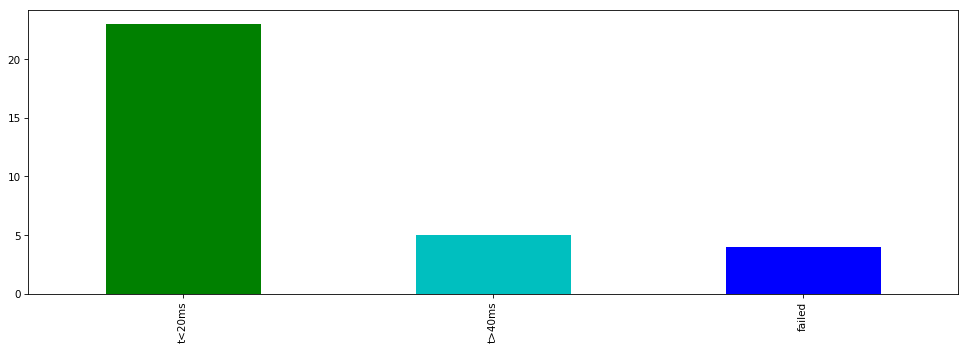

In [23]:
def histogroup(k):
    lat = d['latency'].loc[k]; ok = d['res'].loc[k]
    return "failed" if ok == "ko" else "t<20ms" if lat < 20 else "20ms<t<40ms" if lat < 40 else "t>40ms"
histo = d.groupby(histogroup)['id'].count()
ordered_labels = ["t<20ms", "20ms<t<40ms", "t>40ms","failed"]; colors = ['g', 'c', 'b', 'r']
histo = histo.reindex(pd.Categorical(histo.index,categories=ordered_labels,ordered=True)).sort_index()
histo.plot.bar(color=colors);

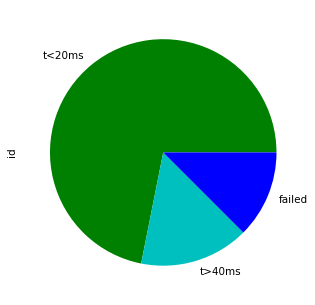

In [24]:
histo.plot.pie(colors=colors,figsize=(5,5));

In [25]:
def okcount(x):
    return x[x == 'ok'].count()
def kocount(x):
    return x[x == 'ko'].count()
def koper(x):
    return 100*(x[x == 'ko'].count() / x.count())
def pct95th(x):
    return x.quantile(0.95)
def pct99th(x):
    return x.quantile(0.99)
def reqpersec(x):
    return x.groupby(x.apply(lambda y: y.floor('s'))).count().mean()
d.groupby(["grouppath"]).agg({'res': ['count',okcount,kocount,koper],'latency': ['mean','std','min','max',pct95th,pct99th],'ts': [reqpersec]})

res                              latency                \
                 count okcount kocount  koper          mean           std   
grouppath                                                                   
/aggregate-stats    28      28       0    0.0   8100.071429  20201.927469   
/order               2       0       2  100.0      7.500000      6.363961   
/orders              2       0       2  100.0  89026.500000  40877.135914   

                                                             ts  
                    min     max    pct95th    pct99th reqpersec  
grouppath                                                        
/aggregate-stats      0   58988   56558.30   58428.56       1.0  
/order                3      12      11.55      11.91       1.0  
/orders           60122  117931  115040.55  117352.91       1.0

## Temps de réponse (ms)

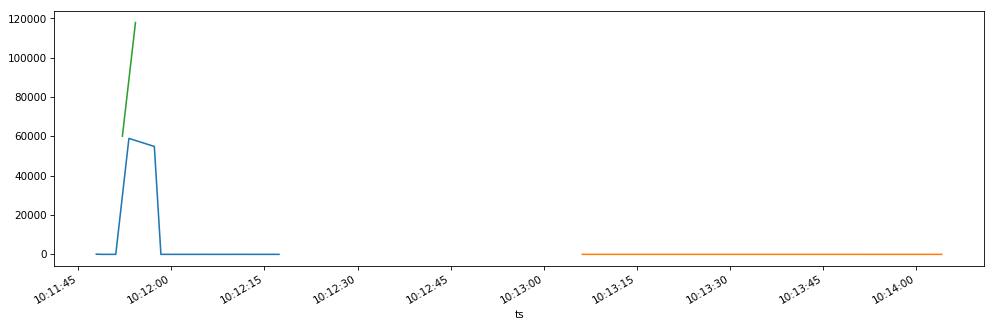

In [26]:
d.groupby(d['grouppath'])['latency'].plot();

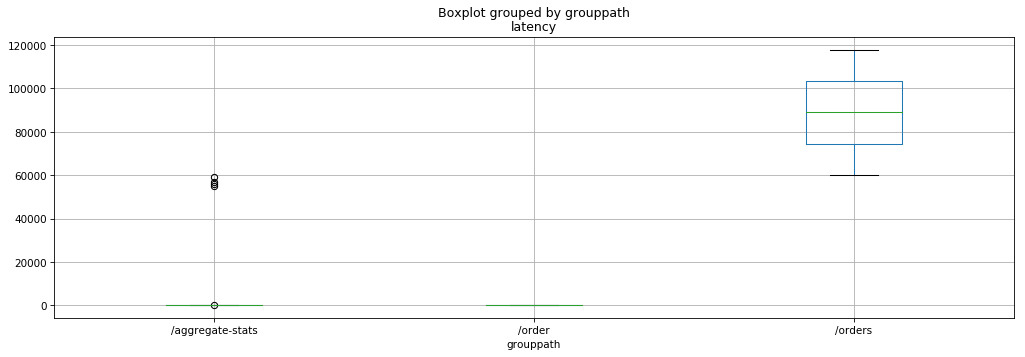

In [27]:
d.boxplot(column=['latency'], by='grouppath');